In [1]:
import numpy as np
from time import time
import os
import sys
import scipy
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.linalg import toeplitz
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import RidgeCV
from sklearn.cluster import KMeans
from skimage.filters import threshold_triangle

sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants

from bigbrain.brain import get_dims
from bigbrain.brain import bleaching_correction
from bigbrain.brain import z_score_brain
from bigbrain.brain import get_resolution
from bigbrain.brain import load_numpy_brain
from bigbrain.brain import save_brain
from bigbrain.fictrac import load_fictrac
from bigbrain.fictrac import prep_fictrac
from bigbrain.utils import load_timestamps
from bigbrain.utils import get_fly_folders
from bigbrain.utils import send_email
from bigbrain.glm import fit_glm
from bigbrain.glm import save_glm_map
from bigbrain.motcorr import get_motcorr_brain

import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import plotly.io as pio
plotly.tools.set_credentials_file(username='lukebrez', api_key='yDoM34yleK2vBoZqCAK0')

### Load template and meanbrain

In [2]:
root_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging'
meanbrain_file = os.path.join(root_path, '20190224_anatomy_central', '20190318_meanbrain', 'syn','mean3.nii')
meanbrain = load_numpy_brain(meanbrain_file)

In [3]:
template_file = os.path.join(root_path, '20190224_anatomy_central', 'meanbrain1', 'JFRCtemplate2010.nii')
template = load_numpy_brain(template_file)

### Match orientations

In [4]:
template = np.swapaxes(template,0,1)
template = template[:,:,::-1]

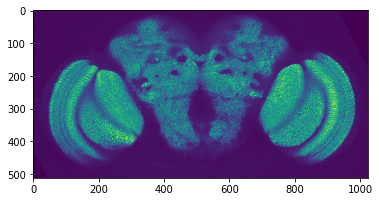

In [9]:
plt.imshow(template[:,:,50])
plt.show()

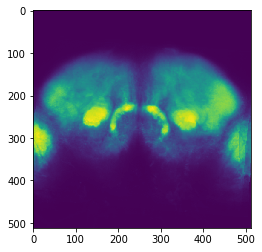

In [8]:
plt.imshow(meanbrain[:,:,50])
plt.show()

### Convert to ants and set correct resolution

In [10]:
meanbrain_ants = ants.from_numpy(meanbrain)
template_ants = ants.from_numpy(template)

In [64]:
template_ants

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (512, 1024, 218)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [11]:
ants.set_spacing(template_ants, (0.622, 0.622, 0.622))
ants.set_spacing(meanbrain_ants, (0.768, 0.768, 1))

### Align

In [12]:
t0 = time()
out = ants.registration(meanbrain_ants, template_ants, type_of_transform='SyN')
print(time() - t0)

346.8651921749115


In [13]:
save_file = os.path.join(root_path, '20190224_anatomy_central', '20190318_meanbrain', 'template', 'template2mean.nii')
save_brain(save_file, out['warpedmovout'].numpy())

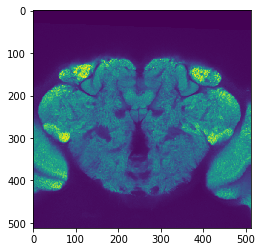

In [14]:
plt.imshow(out['warpedmovout'].numpy()[:,:,130])
plt.show()

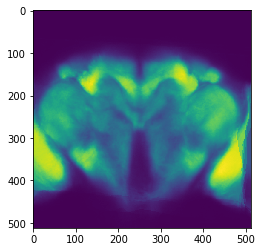

In [15]:
plt.imshow(meanbrain[:,:,130])
plt.show()

### OK for now. Now, load and pull in the ROIs

In [16]:
roi_file = os.path.join(root_path, '20190224_anatomy_central', 'meanbrain1', 'JFRCtempate2010.mask130819_Original.nii')
roi = load_numpy_brain(roi_file)

In [17]:
roi = np.swapaxes(roi,0,1)
roi = roi[:,:,::-1]

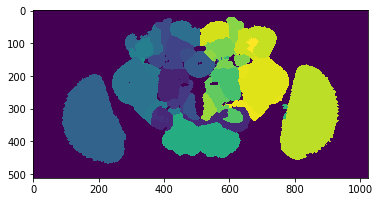

In [18]:
plt.imshow(roi[:,:,130])
plt.show()

In [19]:
roi_ants = ants.from_numpy(roi)
ants.set_spacing(roi_ants, (0.622, 0.622, 0.622))

### Apply transform

In [20]:
roi_warped = ants.apply_transforms(meanbrain_ants, roi_ants, out['fwdtransforms'], interpolator='genericLabel')

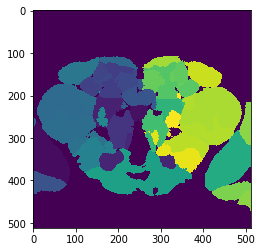

In [21]:
plt.imshow(roi_warped.numpy()[:,:,130])
plt.show()

In [22]:
save_file = os.path.join(root_path, '20190224_anatomy_central', '20190318_meanbrain', 'template', 'roi2mean.nii')
save_brain(save_file, roi_warped.numpy())

### Looks good. Now pull this into an individual brain

In [32]:
anatomy_file = os.path.join(root_path, '20190101_walking_dataset', 'fly_24', 'anatomy.nii')
anatomy = load_numpy_brain(anatomy_file)

In [33]:
anatomy = np.swapaxes(anatomy, 0, 1)

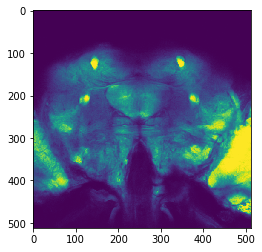

In [34]:
plt.imshow(anatomy[:,:,100])
plt.show()

In [35]:
anatomy_ants = ants.from_numpy(anatomy)

In [36]:
anatomy_ants.set_spacing((0.768, 0.768, 1))

In [37]:
anatomy_ants

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (512, 512, 251)
	 Spacing    : (0.768, 0.768, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [38]:
mean2anat = ants.registration(anatomy_ants, meanbrain_ants, type_of_transform='SyN')

In [39]:
save_file = os.path.join(root_path, '20190101_walking_dataset', 'fly_24', 'warp', 'mean2anat.nii')
save_brain(save_file, mean2anat['warpedmovout'].numpy())

### Looks good. Apply these transforms to rois.

In [40]:
roi_warped2indiv = ants.apply_transforms(anatomy_ants, roi_warped, mean2anat['fwdtransforms'], interpolator='genericLabel')

In [41]:
save_file = os.path.join(root_path, '20190101_walking_dataset', 'fly_24', 'warp', 'roi2anat.nii')
save_brain(save_file, roi_warped2indiv.numpy())

### Since both the template->mean and mean->individual are slightly off, this compounds and the end result is not good enough. Let's press forward for lab meeting, but need to revisit improving these alignments.

### Let's try to extract speed maps into their corresponding rois

### First need to align anatomy to functional mean

In [42]:
file = os.path.join(root_path, '20190101_walking_dataset', 'fly_24', 'functional.nii')
mean_func = load_numpy_brain(file)

In [44]:
mean_func = np.mean(mean_func[:,:,:,:,1], axis=-1)

In [47]:
mean_func = np.swapaxes(mean_func,0,1)

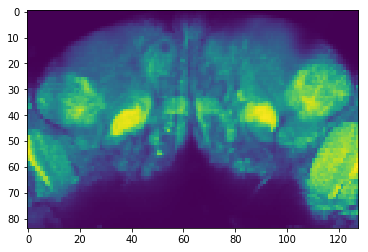

In [48]:
plt.imshow(mean_func[:,:,10])
plt.show()

In [49]:
mean_func_ants = ants.from_numpy(mean_func)
mean_func_ants.set_spacing((3.072, 3.071, 5))

In [50]:
mean_func_ants

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (84, 128, 51)
	 Spacing    : (3.072, 3.071, 5.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [51]:
anat2func = ants.registration(mean_func_ants, anatomy_ants, type_of_transform='SyN')

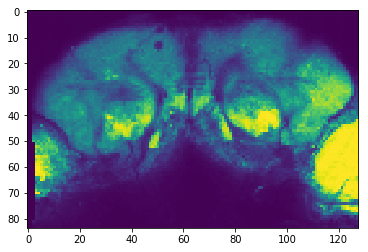

In [52]:
plt.imshow(anat2func['warpedmovout'].numpy()[:,:,8])
plt.show()

### Now need to apply these warp params to roi2anat

In [53]:
roi2speed = ants.apply_transforms(mean_func_ants, roi_warped2indiv, anat2func['fwdtransforms'], interpolator='genericLabel')

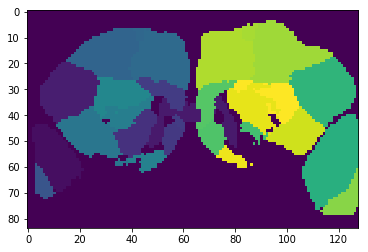

In [54]:
plt.imshow(roi2speed.numpy()[:,:,8])
plt.show()

In [55]:
save_file = os.path.join(root_path, '20190101_walking_dataset', 'fly_24', 'warp', 'roi2func.nii')
save_brain(save_file, roi2speed.numpy())

# Make ROI --> Individual Alignment Loop

In [73]:
root_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'
desired_flies = [14,15,17,19,22,23,24,25,26] # 1 index
flies = get_fly_folders(root_path, desired_flies)

fly folders: ['fly_14', 'fly_15', 'fly_17', 'fly_19', 'fly_22', 'fly_23', 'fly_24', 'fly_25', 'fly_26']


In [76]:
### Load meanbrain
print('Loading meanbrain')
root_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging'
meanbrain_file = os.path.join(root_path, '20190224_anatomy_central', '20190318_meanbrain', 'syn','mean3.nii')
meanbrain = load_numpy_brain(meanbrain_file)
meanbrain_ants = ants.from_numpy(meanbrain)
ants.set_spacing(meanbrain_ants, (0.768, 0.768, 1))

### Load roi2mean
print('Loading roi2mean')
roi_file = os.path.join(root_path, '20190224_anatomy_central', '20190318_meanbrain', 'template', 'roi2mean.nii')
roi = load_numpy_brain(roi_file)
roi_ants = ants.from_numpy(roi)
ants.set_spacing(roi_ants, (0.768, 0.768, 1))

#######################
### Loop Over Flies ###
#######################

for i, fly in enumerate(flies):
    t0=time()
    print('Starting fly {} of {}'.format(i+1, len(flies)))

    ### Create warp directory
    subfolder = 'warp'
    warp_directory = os.path.join(fly, subfolder)
    if not os.path.exists(warp_directory):
        os.makedirs(warp_directory)
    
    ### Load anatomy
    print('Loading anatomy')
    anatomy_file = os.path.join(fly, 'anatomy.nii')
    anatomy = load_numpy_brain(anatomy_file)
    anatomy = np.swapaxes(anatomy, 0, 1)
    anatomy_ants = ants.from_numpy(anatomy)
    anatomy_xml_file = os.path.join(fly, 'anatomy.xml')
    anatomy_ants.set_spacing(get_resolution(anatomy_xml_file))

    ### Warp meanbrain to anatomy
    print('Warping meanbrain to anatomy')
    mean2anat = ants.registration(anatomy_ants, meanbrain_ants, type_of_transform='SyN')
    save_file = os.path.join(warp_directory, 'mean2anat.nii')
    save_brain(save_file, mean2anat['warpedmovout'].numpy())

    ### Apply transforms to ROIs
    print('Applying meanbrain --> anatomy transforms to ROIs')
    roi2anat = ants.apply_transforms(anatomy_ants, roi_ants,mean2anat['fwdtransforms'], interpolator='genericLabel')
    save_file = os.path.join(warp_directory, 'roi2anat.nii')
    save_brain(save_file, roi2anat.numpy())

    ### Load mean_func
    print('Loading functional')
    file = os.path.join(fly, 'functional.nii')
    mean_func = load_numpy_brain(file, channel='green')
    mean_func = np.mean(mean_func, axis=-1)
    mean_func = np.swapaxes(mean_func,0,1)
    mean_func_ants = ants.from_numpy(mean_func)
    func_xml_file = os.path.join(fly, 'functional.xml')
    mean_func_ants.set_spacing(get_resolution(func_xml_file))

    ### Align anatomy to functional
    print('Warping anatomy to functional')
    anat2func = ants.registration(mean_func_ants, anatomy_ants, type_of_transform='SyN')

    ### Apply transforms to ROIs
    print('Applying anatomy --> functional transforms to ROIs')
    roi2func = ants.apply_transforms(mean_func_ants, roi2anat,anat2func['fwdtransforms'], interpolator='genericLabel')
    save_file = os.path.join(warp_directory, 'roi2func.nii')
    save_brain(save_file, roi2func.numpy())
    print('Duration: {:.2f} min'.format((time()-t0)/60))

Loading meanbrain
Loading roi2mean
Starting fly 1 of 9
Loading anatomy
Warping meanbrain to anatomy
Applying meanbrain --> anatomy transforms to ROIs
Loading functional
Warping anatomy to functional
Applying anatomy --> functional transforms to ROIs
Duration: -4.69 min
Starting fly 2 of 9
Loading anatomy
Warping meanbrain to anatomy
Applying meanbrain --> anatomy transforms to ROIs
Loading functional
Warping anatomy to functional
Applying anatomy --> functional transforms to ROIs
Duration: -4.65 min
Starting fly 3 of 9
Loading anatomy
Warping meanbrain to anatomy
Applying meanbrain --> anatomy transforms to ROIs
Loading functional
Warping anatomy to functional
Applying anatomy --> functional transforms to ROIs
Duration: -4.16 min
Starting fly 4 of 9
Loading anatomy
Warping meanbrain to anatomy
Applying meanbrain --> anatomy transforms to ROIs
Loading functional
Warping anatomy to functional
Applying anatomy --> functional transforms to ROIs
Duration: -6.59 min
Starting fly 5 of 9
Loadi

# Great, we have rois aligned to glm maps. Now we need to extract signals

In [246]:
root_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'
desired_flies = [14,17,19,22,23,24,25,26] # 1 index
flies = get_fly_folders(root_path, desired_flies)

fly folders: ['fly_14', 'fly_17', 'fly_19', 'fly_22', 'fly_23', 'fly_24', 'fly_25', 'fly_26']


In [160]:
legit_nums = [2,3,4,5,6,7,8,9,10,
              11,12,13,14,15,16,17,18,19,
              20,22,23,24,25,26,27,28,29,
              30,31,32,33,34,35,36,37,38,39,
              40,49,
              50,51,52,53,54,55,56,57,58,59,
              60,61,62,63,64,65,66,67,69,
              70,71,72,73,74,75,76,77,78,79,
              80,81,82,83,84,85,86]

names_file = os.path.join('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/', '20190224_anatomy_central', '20190318_meanbrain', 'names.txt')
names_raw = np.genfromtxt(names_file, delimiter='\t',skip_header=1,usecols=(0,),dtype=str)
names = []
for row in names_raw:
    names.append(row.split(' ')[0])

In [332]:
values_rot_master = []
for i, fly in enumerate(flies):
    print('Starting fly {} of {}'.format(i+1, len(flies)))
    
    ### Load glm brain
    try:
        brain_file = os.path.join(fly, 'glm', 'multivariate_analysis_green_dRotLabZ.nii')
        brain = load_numpy_brain(brain_file)
    except:
        print('breaking')
        break
        #brain_file = os.path.join(fly, 'glm', 'multivariate_analysis_green.nii')
        #brain = load_numpy_brain(brain_file)
    brain = np.swapaxes(brain,0,1)

    ### Load warped roi
    roi_file = os.path.join(fly, 'warp', 'roi2func.nii')
    roi = load_numpy_brain(roi_file)
    
    ### Convert to ants
    brain_ants = ants.from_numpy(brain)
    roi_ants = ants.from_numpy(roi)
    
    ### Make ones array (for size control, later)
    ones_brain = np.ones((roi.shape))
    ones_ants = ants.from_numpy(ones_brain)
    
    ### Extract ROI signals
    values = []
    sizes = []
    roi_num = []

    for i in legit_nums:
        roi_num.append(i)
        value = ants.mask_image(brain_ants, roi_ants,level=[i]).numpy()
        values.append(np.sum(value))
        size = ants.mask_image(ones_ants, roi_ants,level=[i]).numpy()
        sizes.append(np.sum(size))
        
    values = np.asarray(values)
    sizes = np.asarray(sizes)
    values_norm = values/sizes
    values_rot_master.append(values_norm)

Starting fly 1 of 8
Starting fly 2 of 8
Starting fly 3 of 8
Starting fly 4 of 8
Starting fly 5 of 8
Starting fly 6 of 8
Starting fly 7 of 8
Starting fly 8 of 8


In [333]:
values_rot_master_array = np.asarray(values_rot_master)
mean_values = np.mean(values_rot_master_array,axis=1)
values_rot_master_array_norm = values_rot_master_array/mean_values[:,np.newaxis]

In [334]:
### Sort by means
mean_values = np.mean(values_rot_master_array_norm,axis=0)
sort_indicies = np.argsort(mean_values)
values_rot_master_array_norm_sorted = values_rot_master_array_norm[:,sort_indicies[::-1]]
names_sorted = np.asarray(names)[sort_indicies[::-1]]

In [336]:
data = []
for i in range(len(names)):
    #each "Data" is an roi
    trace = go.Box(
            name=names_sorted[i],
            y=values_rot_master_array_norm_sorted[:,i],
            boxpoints='all',
            jitter=0.3,
            pointpos = 0)
    data.append(trace)

layout = go.Layout(
    showlegend=False,
    margin=go.Margin(
    l=50,
    r=100,
    b=200
),
    xaxis=dict(
        showticklabels=True,
        tickangle=90,
        gridwidth=2,
        tickfont=dict(
            #family='Old Standard TT, serif',
            size=8,
            color='black'
        )))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

/home/users/brezovec/.local/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:396: DeprecationWarning:

plotly.graph_objs.Margin is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Margin




# Let's try aligning all func maps to meanbrain to make a mean functional map

In [361]:
### Load meanbrain
print('Loading meanbrain')
root_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging'
meanbrain_file = os.path.join(root_path, '20190224_anatomy_central', '20190318_meanbrain', 'syn','mean3.nii')
meanbrain = load_numpy_brain(meanbrain_file)
meanbrain_ants = ants.from_numpy(meanbrain)
ants.set_spacing(meanbrain_ants, (0.768, 0.768, 1))

#######################
### Loop Over Flies ###
#######################

for i, fly in enumerate(flies):
    t0=time()
    print('Starting fly {} of {}'.format(i+1, len(flies)))

    ### Create warp directory
    subfolder = 'warp'
    warp_directory = os.path.join(fly, subfolder)
    if not os.path.exists(warp_directory):
        os.makedirs(warp_directory)
    
    ### Load anatomy
    print('Loading anatomy')
    anatomy_file = os.path.join(fly, 'anatomy.nii')
    anatomy = load_numpy_brain(anatomy_file)
    anatomy = np.swapaxes(anatomy, 0, 1)
    anatomy_ants = ants.from_numpy(anatomy)
    anatomy_xml_file = os.path.join(fly, 'anatomy.xml')
    anatomy_ants.set_spacing(get_resolution(anatomy_xml_file))

    ### Load mean_func
    print('Loading functional')
    file = os.path.join(fly, 'functional.nii')
    mean_func = load_numpy_brain(file, channel='green')
    mean_func = np.mean(mean_func, axis=-1)
    mean_func = np.swapaxes(mean_func,0,1)
    mean_func_ants = ants.from_numpy(mean_func)
    func_xml_file = os.path.join(fly, 'functional.xml')
    mean_func_ants.set_spacing(get_resolution(func_xml_file))

    ### Load glm map
    print('Loading glm map')
    try:
        file = os.path.join(fly, 'glm', 'multivariate_analysis_green_speed.nii')
        glm = load_numpy_brain(file)
    except:
        file = os.path.join(fly, 'glm', 'multivariate_analysis_green.nii')
        glm = load_numpy_brain(file)
    glm = np.swapaxes(glm,0,1)
    glm_ants = ants.from_numpy(glm)
    func_xml_file = os.path.join(fly, 'functional.xml')
    glm_ants.set_spacing(get_resolution(func_xml_file))
    
    ### Downsample anatomy, downsample mean_func, downsample meanbrain
    anatomy_ants = ants.resample_image(anatomy_ants, glm_ants.spacing)
    mean_func_ants = ants.resample_image(mean_func_ants, glm_ants.spacing)
    meanbrain_downsampled = ants.resample_image(meanbrain_ants, glm_ants.spacing)
    
    
    ### Align functional to anatomy
    print('Warping functional to anatomy')
    func2anat = ants.registration(anatomy_ants, mean_func_ants, type_of_transform='SyN')
    
    ### Apply transforms to glm
    print('Applying functional --> anatomy transforms to glm')
    glm2anat = ants.apply_transforms(anatomy_ants, glm_ants, func2anat['fwdtransforms'])
    save_file = os.path.join(warp_directory, 'glm2anat_down.nii')
    save_brain(save_file, glm2anat.numpy())
    
    
    ### Warp anatomy to meanbrain
    print('Warping anatomy to meanbrain')
    anat2mean = ants.registration(meanbrain_downsampled, anatomy_ants, type_of_transform='SyN')
    save_file = os.path.join(warp_directory, 'anat2mean_down.nii')
    save_brain(save_file, anat2mean['warpedmovout'].numpy())

    ### Apply transforms to glm
    print('Applying anatomy --> meanbrain transforms to glm')
    glm2mean = ants.apply_transforms(meanbrain_downsampled,glm2anat,anat2mean['fwdtransforms'])
    save_file = os.path.join(warp_directory, 'glm2mean_down.nii')
    save_brain(save_file, glm2mean.numpy())
    print('Duration: {:.2f} min'.format((time()-t0)/60))

Loading meanbrain
Starting fly 1 of 8
Loading anatomy
Loading functional
Loading glm map
Warping functional to anatomy
Applying functional --> anatomy transforms to glm
Warping anatomy to meanbrain
Applying anatomy --> meanbrain transforms to glm
Duration: 1.19 min
Starting fly 2 of 8
Loading anatomy
Loading functional
Loading glm map
Warping functional to anatomy
Applying functional --> anatomy transforms to glm
Warping anatomy to meanbrain
Applying anatomy --> meanbrain transforms to glm
Duration: 1.29 min
Starting fly 3 of 8
Loading anatomy
Loading functional
Loading glm map
Warping functional to anatomy
Applying functional --> anatomy transforms to glm
Warping anatomy to meanbrain
Applying anatomy --> meanbrain transforms to glm
Duration: 1.40 min
Starting fly 4 of 8
Loading anatomy
Loading functional
Loading glm map
Warping functional to anatomy
Applying functional --> anatomy transforms to glm
Warping anatomy to meanbrain
Applying anatomy --> meanbrain transforms to glm
Duration:

In [378]:
meanbrain_downsampled

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (128, 128, 50)
	 Spacing    : (3.072, 3.072, 5.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [382]:
meanbrain_ants

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (512, 512, 251)
	 Spacing    : (0.768, 0.768, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [371]:
brains = []
for i, fly in enumerate(flies):
    if i is not 0:
        load_file = os.path.join(fly, 'warp', 'glm2mean_down.nii')
        brain = load_numpy_brain(load_file)
        brains.append(brain)

In [373]:
brains[0].shape

(128, 128, 50)

In [374]:
brain_array = np.asarray(brains)
mean_glm = np.mean(brain_array, axis=0)

In [377]:
save_file = os.path.join(root_path, '20190224_anatomy_central', '20190318_meanbrain', 'syn','glm2mean_down.nii')
save_brain(save_file, mean_glm)

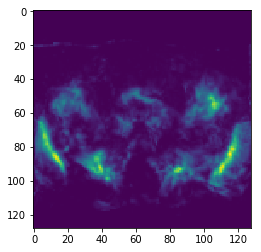

In [376]:
plt.imshow(mean_glm[:,:,20])
plt.show()

In [379]:
glm_ants = ants.from_numpy(mean_glm)

In [380]:
glm_ants.set_spacing((3.072,3.072,5))

In [385]:
glm_ants_big = ants.resample_image(glm_ants, (512, 512, 251),use_voxels=True)

In [387]:
save_file = os.path.join(root_path, '20190224_anatomy_central', '20190318_meanbrain', 'syn','glm2mean_up.nii')
save_brain(save_file, glm_ants_big.numpy())

### REMAKE MEANBRAIN

In [125]:
root_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'
desired_flies = [17, 25] # 1 index
folders = get_fly_folders(root_path, desired_flies)
print(folders)

fly folders: ['fly_17', 'fly_25']
['/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_17', '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_25']


In [128]:
anatomy_files = []
for folder in folders:
    anatomy_files.append(os.path.join(folder, 'anatomy.nii'))

In [129]:
brains = []
for brain_file in anatomy_files:
    full_file = os.path.join(root_path, brain_file)
    brains.append(load_numpy_brain(full_file))

In [130]:
# rotate brains
for i in range(len(brains)):
    brains[i] = np.swapaxes(brains[i],0,1)

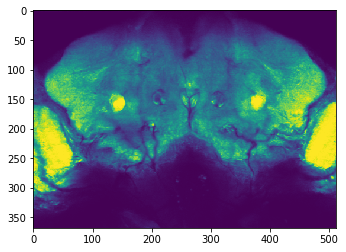

In [131]:
plt.imshow(brains[1][:,:,100])
plt.show()

In [132]:
master_ants = ants.from_numpy(brains[1])
master_ants.set_spacing((0.768, 0.768, 1))
slave_ants = ants.from_numpy(brains[0])
slave_ants.set_spacing((0.768, 0.768, 1))

In [133]:
master_n4 = ants.n4_bias_field_correction(master_ants)
slave_n4 = ants.n4_bias_field_correction(slave_ants)

In [155]:
master_n4_smooth = ants.smooth_image(master_n4, sigma=1)
slave_n4_smooth = ants.smooth_image(slave_n4, sigma=1)

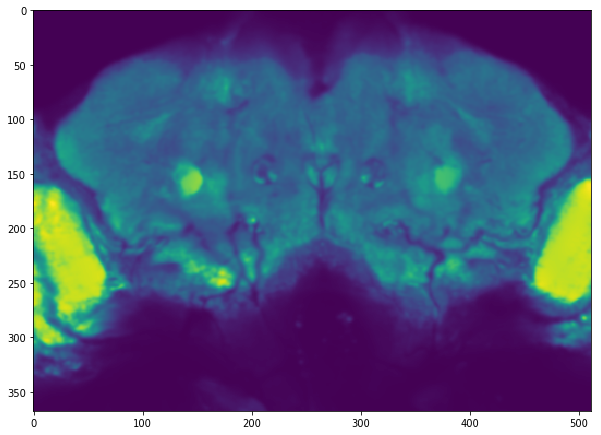

In [154]:
plt.figure(figsize=(10,10))
plt.imshow(master_n4_smooth.numpy()[:,:,100])
plt.show()

In [156]:
t0 = time()
slave2master = ants.registration(master_n4_smooth,
                                 slave_n4_smooth,
                                 type_of_transform='SyN')
print(time() - t0)

279.39022493362427


In [157]:
save_file = os.path.join('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/', '20190224_anatomy_central', '20190318_meanbrain', 'slave2master_smooth1.nii')
save_brain(save_file, slave2master['warpedmovout'].numpy())

In [ ]:
grad_step=0.2,
                                 flow_sigma=10,
                                 total_sigma=3,